# Problem Statement
Consider the samples from the World Wide Web that are provided in the data sets for Chapter 5 of LNR. Choose one of those samples and compute its degree distribution.  Use that to choose one of the evolving network models we studied in this module and proceed to fit that model to the sample data you chose.  

Now construct a subsample of no more than $N$ nodes, stipulating that two nodes in the subsample are connected if and only if the distance between them in the original sample was no more than $D$.  Perform the same analysis as above.  

What is the uncertainty of your model choice and parameter estimates?  How does the accuracy of you analysis improve as $N$ and $D$ increase?  How large do they need to be for your model choice and parameter estimates to be robust?


In [220]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy.optimize

In [221]:
# Important constants
N = 325729
K = 1469680
k_min = 1 # ignore isolated nodes
file_name = "./www/web-NotreDame.net"

In [213]:
# Importing dataset as an edge list (note the dataset is directed and unweighted)
# Read data from `file_name` while calculating degrees
E = np.zeros((K,2))

with open(file_name, "r") as data_file:
    for it, line in enumerate(data_file.readlines()):
        tail, head = [int(k) for k in line.split()]
        E[it,0] = tail
        E[it,1] = head

# Relabel edges in storage from 0 to 875712, inclusive
_labels = dict(zip(np.sort(np.unique(E)), range(len(np.unique(E)))))
_relabel = np.vectorize(lambda index: _labels[index])
E = _relabel(E)

In [170]:
# Calculate degrees of nodes in network
D_in = np.zeros(N)
D_out = np.zeros(N)

for row in E:
    D_out[row[0]] += 1
    D_in[row[1]] += 1

## Visualizing in- and out-degree distributions

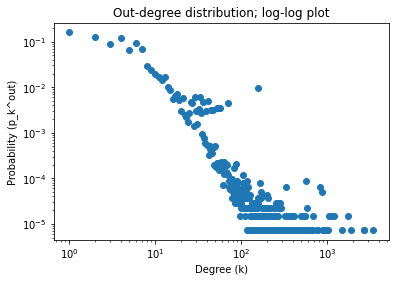

In [222]:
degrees_out, frequencies_out = np.unique(D_out[D_out >= k_min], return_counts=True)
probabilities_out = frequencies_out * 1/(len(D_out) - np.count_nonzero(D_out < k_min))

plt.title("Out-degree distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Probability (p_k^out)")
plt.scatter(degrees_out, probabilities_out)
plt.show()

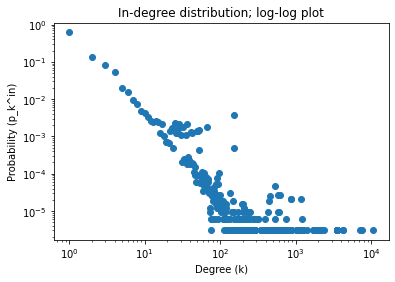

In [223]:
degrees_in, frequencies_in = np.unique(D_in[D_in >= k_min], return_counts=True)
probabilities_in = frequencies_in * 1/(len(D_in) - np.count_nonzero(D_in < k_min))

plt.title("In-degree distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Probability (p_k^in)")
plt.scatter(degrees_in, probabilities_in)
plt.show()

Clearly the data seems to behave as a power-law distribution $f(x)=cx^{-\gamma}$, so we now move to determine the values of these paramters by utilizing *cumulative distribution functions*. Note that the cumulative distribution function $P(k)$ of a power-law distribution $p(k)=ck^{-\gamma}$ is simply

$\displaystyle P(k)=c\int_k^{\infty} x^{-\gamma}\;dx=\frac{c}{\gamma-1}k^{-(\gamma-1)}$.

In [224]:
cumulative_probabilities_out = np.array([np.sum(probabilities_out[k:]) for k in range(len(degrees_out))])
cumulative_probabilities_in = np.array([np.sum(probabilities_in[k:]) for k in range(len(degrees_in))])

## Calculating $\gamma$ values
Through the code below we see that...
- $\gamma^{in}=2.43$ and $\gamma^{out}=3.97$ for the Google dataset.
- $\gamma^{in}=2.50$ and $\gamma^{out}=2.84$ for the Notre Dame dataset.

In [234]:
def power_law(x, gamma, c):
    return gamma * x + np.log(c) # Linear function when converted back to linear space becomes an exponential c * x^\gamma.

in_opt, in_cov = scipy.optimize.curve_fit(power_law, np.log(degrees_in), np.log(cumulative_probabilities_in))
out_opt, out_cov = scipy.optimize.curve_fit(power_law, np.log(degrees_out), np.log(cumulative_probabilities_out))

# We can recover coefficients:
in_gamma = -(in_opt[0]-1)
out_gamma = -(out_opt[0]-1)
in_c = in_opt[1]*(-in_opt[0])
out_c = out_opt[1]*(-out_opt[0])
print("IN gamma: {}, c: {}".format(in_gamma, in_c))
print("OUT gamma: {}, c: {}".format(out_gamma, out_c))

IN gamma: 2.443892490703324, c: 3.8986899478706127
OUT gamma: 2.696062541974041, c: 34.146250990394684


## Plotting cumulative distributions with corresponding functions

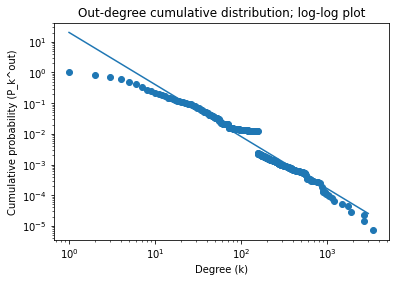

In [235]:
plt.title("Out-degree cumulative distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Cumulative probability (P_k^out)")
plt.scatter(degrees_out, cumulative_probabilities_out)
plt.plot(np.arange(1,3000,0.1), (out_c/(out_gamma-1))*np.arange(1,3000,0.1)**(-out_gamma+1))
plt.show()

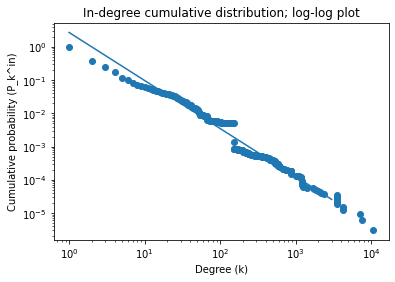

In [236]:
plt.title("In-degree cumulative distribution; log-log plot")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree (k)")
plt.ylabel("Cumulative probability (P_k^in)")
plt.scatter(degrees_in, cumulative_probabilities_in)
plt.plot(np.arange(1,3000,0.1), (in_c/(in_gamma-1))*np.arange(1,3000,0.1)**(-in_gamma+1))
plt.show()

# Fitting the Barabasi-Albert (BA) model